# Chapter 18. Reinforcement Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import tensorflow.keras as keras
import gym

%matplotlib inline
np.random.seed(0)
sns.set_style('whitegrid')

## Learning to optimize rewards

To set the stage: in reinforcement learning, a software *agent* makes *observations* and takes *actions* within an *environment*, and in return it receives *rewards*.
Its objective is to learn to act in a way that will maximize its expected rewards over time.

### Policy search

The algorithm a software agent uses to determine its action is called its *policy*.
It can be any algorithm, including a neural network, and needs not be deterministic.
The parameters of the policy that can be learned or tweaked are the *policy parameters*.
The *policy search* is the method (e.g. brute force) used to identify good values in the *policy space* for the policy parameters.

*Genetic algorithms* are a popular method for exploring the policy space.
This algorithm involves creating 100 policies and trying them all.
The 80 worst policies are "killed" while the rest "reproduce" 4 offspring each, introducing some random variation in each offspring.
This method continues until a sufficiently good model is created.

Alternatively, an optimization technique can be used to tweak the parameters and follow the gradient of the results.
This is called *policy search* and will be discussed more thoroughly later in the chapter.

## Introduction to OpenAI Gym

[OpenAI Gym](https://gym.openai.com) is a toolkit providing a variety of simulated environments including board games, Atari games, 2D and 2D physical simulations, and more for training RL algorithms.

Here is a breif example of the ["cart-pole" problem](https://gym.openai.com/envs/CartPole-v1/).
An environment is made with `gym.make()` and initialized using `env.reset()`, which also returns the first data point.
This returns a 1D vector with 4 values: the cart's horizontal position, velocity, the angle of the pole, and its angular velocity.

In [2]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([ 0.00369344, -0.03429507, -0.01185087,  0.04203845])

The environment can be rendered using its `render()` method.

In [3]:
env.render()

# close the window
env.close()

<img src="assets/ch18/images/cart-pole-firstposition.png" width=500 >

We can ask the environment what the possible actions are, too.
For this problem, there are two options: 0 = left, 1 = right.

In [4]:
env.action_space

Discrete(2)

Since the pole is slightly learning to the left, we will move the cart to the left using the `step()` method of the environment.
This method returns four values:

* `obs`: The new observation to act on.
* `reward`: In this game, the reward is always 1 because the point is to keep the pole up for as long as possible.
* `done`: This value will be true when the episode is over; for this game that means the pole tilts too much, the cart goes off screen, or there have been 200 steps, where fulfilling the last condition means the algorithm has won. An environment must be reset when the episode has finished.
* `info`: An environment-specific dictionary to provide extra information.

Finally, it is good practice to call the `close()` method on an environment to free the resources it is taking.

In [5]:
action = 0
obs, reward, done, info = env.step(action)
obs

array([ 0.00300754, -0.2292451 , -0.0110101 ,  0.33095888])

In [6]:
reward

1.0

In [7]:
done

False

In [8]:
info

{}

In [9]:
env.close()

The following code would generate a demonstration video of the cart-pole problem.

```python
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()
```

As an example, we will hardcode a simple policy: accelerate left when the pole is leaning left and accelerate right when the pole is leaning right.

In [10]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [11]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

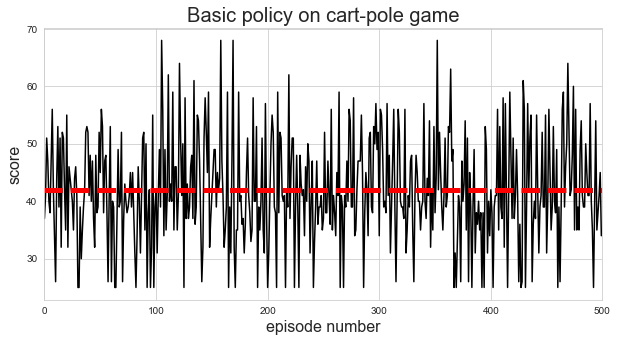

In [12]:
avg_score = np.mean(totals)

fig = plt.figure(figsize=(10, 5))
plt.plot(totals, 'k-')
plt.plot([0, len(totals)], [avg_score, avg_score], 'r--', linewidth=5)
plt.title("Basic policy on cart-pole game", fontsize=20)
plt.xlabel('episode number', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xlim(0, len(totals))
plt.show()

In [13]:
np.mean(totals), np.median(totals), np.std(totals), np.min(totals), np.max(totals)

(41.936, 41.0, 9.222358917326956, 25.0, 68.0)

## Neural network policies

We will make a single nerual network to play the cart-pole problem.
It will take the four observations as input and output a single probability for left vs. right.
We will then take this probability as the weight for sampling left or right.

In [14]:
n_inputs = 4

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

One difficulty with training this model is telling it out each action affected the game, especially since the action won't necessarily have an immediate impact.
Thus, it is common to evaluate an action's *return*, a weighted sum of all the rewards that follow.
The *discount factor* $\gamma$ is multiplied to the rewards following an action, leading to exponential decay of the effect of future rewards on the action's return.
Further, to help the good actions stand out (called the *action advantage*), we can run the simulation multiple times and normalize the rewards.

## Policy gradients

Here is one variant of a PG algorithm from *REINFORCE algorithms* used to optimize the parameters of a policy (the neural network, in this case):

1. Let the NN play the game several times, computing the gradients that would make the chosen action even more likely (would "reinforce" action) for each round.
2. Compute each action's advantage (as described above).
3. Weight the computed gradients by the advantage to reinforce the good actions and reduce the likelihood of the bad actions.
4. Compute the mean of the resulting gradient vectors and use it to perform a gradient descent step.

We can now implement this algorithm to train the neural network to balance the pole.

First, we make a function to play one step of the cart-pole problem.
Here is how the function works:

1. In the `GradientTape` block, the model is provided a single observation and outputs the probability of moving the car left.
2. The actual decision to go left is made from a random distribution by sampling a uniform distribution and seeing if the output probability was smaller.
3. Then, the action to take is decided as `1 - action` so that the value will be 0 if the model wants to go left, and 1 if the model wants to go right.
4. The loss is calculated as the difference between the output probability of going left and the actual action, taking the chosen action as correct (for now).
5. The tape is used to calculate the gradient of the loss with regard to the model's trainable variables.
6. Finally, the selected action is played in the environment, and the output and the gradient are returned.

In [15]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.0]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

The next function will use the `play_one_step()` function to play multiple episodes, returning the rewards and gradients for each episode and step.
It returns a list of reward lists: one reward list per episode containing one reward per step.
It returns a list of gradient lists: one gradient list per episode, each containing one tuple of gradients per step, the tuples containing one gradient tensor per trainable variable.

At the end of this section, the author recommended using prior knowledge to help the model.
Thus, I used the angle of the pole to reduce the reward as the angle increases in either direction.

In [16]:
def adjust_reward(reward, obs, max_subtraction=0.7):
    return reward - tf.minimum(tf.abs(obs[2]), max_subtraction)

In [17]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            reward = adjust_reward(reward, obs)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

The algorithm will use the `play_multiple_episodes()` function to play the game several time, then discount and normalize the rewards to be used for the reinforcement weights.

We can create a `discount_rewards()` function to compute the sum of future discount rewards at each step.

In [18]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

We can also create a function to normalize the discounted rewards across many episodes.

In [19]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()

    normalized_rewards = [(discounted_rewards - reward_mean) / reward_std
                          for discounted_rewards in all_discounted_rewards]
    return normalized_rewards

Here is a quick test to make sure it works.

In [20]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [21]:
discount_and_normalize_rewards(
    [[10, 0, -50], [10, 20]],
    discount_factor=0.8
)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Finally, we can define some hyperparameters for the model.

In [22]:
n_iterations = 3 # 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

And we need an optimizer and loss function.

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

Finally, we can create the environment.

In [24]:
env = gym.make("CartPole-v1")

Now we can build the training loop.
Here is how it works:

1. For each training iteration, the loop calls `play_multiple_episodes()` to play the game 10 times and return all of the rewards and gradients for each episode and step.
2. The `discount_and_normalize_rewards()` compute each actions normalized advantage.
3. For each trainable variable, the weighted mean of the gradients over all episodes and steps was calculated and weighted by `final_reward`.
4. Finally, the mean gradients were applied using the optimizer.

In [25]:
avg_episode_lengths = []

for iteration in range(n_iterations):
    print(f"iteration {iteration}")
    all_rewards, all_grads = play_multiple_episodes(env,
                                                    n_episodes_per_update,
                                                    n_max_steps,
                                                    model,
                                                    loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)

    all_mean_grads = []
    for var_idx in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_idx][step][var_idx]
             for episode_idx, final_rewards in enumerate(all_final_rewards)
             for step, final_reward in enumerate(final_rewards)],
            axis=0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    
    avg_episode_lengths.append(np.mean([len(x) for x in all_rewards]))

iteration 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

iteration 1
iteration 2


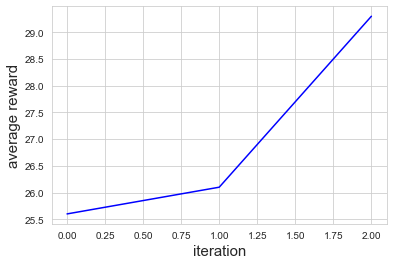

In [26]:
plt.plot(avg_episode_lengths, 'b-')
plt.xlabel('iteration', fontsize=15)
plt.ylabel('average reward', fontsize=15)
plt.show()

In [27]:
if False:
    obs = env.reset()
    for _ in range(300):
        env.render()

        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        obs, reward, done, info = env.step(int(action[0, 0].numpy()))
        
    env.close()

I trained the model on 200 iteration on the HMS computing cluster.
The results of that model are shown below.

In [28]:
o2model = tf.keras.models.load_model(
    'assets/ch18/o2-trained-models/trained-cart-pole.tfmodel'
)

In [29]:
if False:
    obs = env.reset()
    while True:
        env.render()

        left_proba = o2model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        obs, reward, done, info = env.step(int(action[0, 0].numpy()))

        if done:
            break

    env.close()
env.close()

The first video below is the model trained only using the normal reward returned by the gym.

<img src="assets/ch18/images/cart-pole-neural-network.gif" width=500 >

I then implemented an adjustment for the reward based on the angle of the pole.
This worked much better!

<img src="assets/ch18/images/cart-pole-neural-network-2.gif" width=500 >

If I implement an early stopping mechanism to stop training if the model is performing very well for a few iterations, it become much better, still.
It usually finishes the game still holding the pole up-right, meaning it won!

<img src="assets/ch18/images/cart-pole-neural-network-3.gif" width=500 >

Below is the curve of the length of the episodes during the training of the model.
In previous versions, this was how I realized early stopping would be effective.
There are strange periods of poor performance followed by quick advancements.

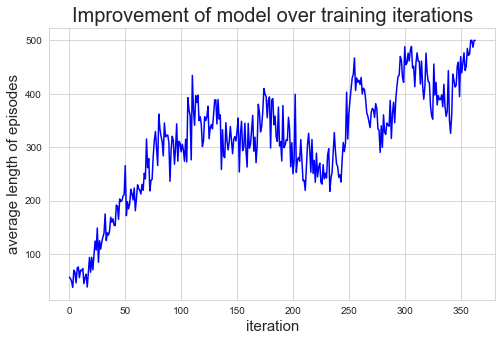

In [30]:
o2_rewards = pd.read_csv(
    'assets/ch18/o2-trained-models/average_episode_lengths.csv'
)

fig = plt.figure(figsize=(8, 5))
plt.plot(o2_rewards.avg_episode_lengths, 'b-')
plt.xlabel('iteration', fontsize=15)
plt.ylabel('average length of episodes', fontsize=15)
plt.title('Improvement of model over training iterations', fontsize=20)
plt.show()

Unfortunately, the approach we used here does not scale well to larger and more complex tasks.
It is highly *sample inefficient* meaning that it requires more time to start making meaningful improvement.
This is primarily due to the fact that it must run multiple episodes to estimate the advantage of each action.

To help alleviate these issues we will learn about other optimization algorithms.
This time where the agent learns to estimate the expected return for each state or action in a state, then use that knowledge to make decisions.
To understand these algorithms, we must first understand *Markov decision processes*.

## Markov decision processes

A *Markov chain* is a process with a fixed number of states and randomly evolves from one to another at each step.
The probability for it to evolve from a state $s$ to $s'$ is fixed and depends only on the pair, not the past states (this is why we say it has no memory).
A *Markov decision process* (MDP) is similar, except that at each step, an agent can choose one of several possible actions, and the actions have transition probabilities to other steps.
In addition, some transitions return a reward (positive or negative).
The agent's goal is to find a policy that maximizes the reward over time.

The *optimal state value* of any state $s$, $V^*(s)$, is the sum of all discounted future rewards the agent can expect on average when it reaches a state $s$, assuming it acts optimally.
The *Bellman Optimality Equation* can calculate this value.

$V^*(s) = \max_a \sum_s T(s, a, s') [R(s, a, s') + \gamma \cdot V^*(s')] \quad$ for all $s$

where:

* $T(s, a, s')$ is the transition probability from state $s$ to $s'$ given the agent chose action $a$
* $R(s, a, s')$ is the reward that the agent receives when it goes from state $s$ to $s'$ given the agent chose action $a$
* $\gamma$ is the discount factor

The *Value Iteration algorithm* can be used to estimate the optimal state value for every possible state (initializing the values at 0).

$V_{k+1}(s) \leftarrow \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \cdot V_k(s')] \quad$ for all $s$

where $V_k(s)$ is the estimate value of state $s$ at the $k^{th}$ iteration of the algorithm.
This recursive algorithm produces the optimal state values to help evaluate a policy, but it does not provide the optimal policy for an agent.
instead, the optimal *state-action values*, generally called *Quality Values* (Q-Values), can be estimated.
The Q-Value of a state-action pair $(s, a)$, $Q^*(s, a)$ is the sum of discounted future rewards the agent can expect on average after it reaches state $s$ and chooses action $a$, but before it sees the outcome of the action.
The *Q-Value Iteration* algorithm can be used to estimate the Q-Values.

$Q_{k+1}(s,a) \leftarrow \sum_{s'} T(s,a,s') [R(s,a,s') + \gamma \cdot \max_{a'} Q_k(s'a')] \quad$ for all $(s',a)$

Once the optimal Q-Values have been found, defining the optimal policy, denoted $\pi^*(s)$, is trival: when the agent is in state $s$, it should choose the action with the highest Q-Value

$
\DeclareMathOperator*{\argmax}{argmax}
\pi^*(s) = \argmax_a Q^*(s, a)
$

(The author demonstrates how to implement this algorithm in Python based on an example in the book.)

## Temporal Difference (TD) Learning

When training a model, however, the states, transition probabilities, and rewards are not known.
Therefore, the model must explore the environment to learn about the possible states.
The *Temporal Difference Learning* (TD Learning) algorithm, is similar to the Value Iteration algorithm, but beginning under the assumption that the model only knows the possible states and actions, but nothing more.
Thus, the agent uses an *exploration policy* (e.g. randomly making decisions) to explore the MDP.
As it learns, it updates the estimates of the state values based on the transitions and rewards that are actually observed.

$
V_{k+1}(s) \leftarrow (1-\alpha)V_{k}(s) + \alpha (r + \gamma \cdot V_k(s')) \\
V_{k+1}(s) \leftarrow V_{k}(s) + \alpha \cdot \delta_k(s, r, s') \\
\quad \text{where} \quad \delta_k(s,r,s') = r + \gamma \cdot V_k(s') - V_k(s)
$

where:

* $\alpha$ is the learning rate
* $r + \gamma \cdot V_k(s')$ is called the *TD target*
* $delta_k(s,r,s')$ is called the *TD error*

For each state $s$, the algorithm keeps a running average of the immediate rewards the agent gets upon choosing an action plus the rewards it expects to get later.

## Q-Learning

The Q-Learning algorithm is an adaptation of the Q-Value Iteration algorithm to the situation where the MDP system values are unknown.
Q-Learns watches an agent play (e.g. randomly) and gradually improves its estimates of the unknown system parameters.
Once the estimates are good enough, the optimal policy is the choose the action with the highest Q-Value (i.e. a greedy policy).

$
Q(s, a) \xleftarrow[\alpha]{} r + \gamma \cdot \max_{a'} Q(s', a')
$

where $a \xleftarrow[\alpha]{} b \,$ means $\, a_{k+1} \leftarrow (1-\alpha) \cdot a_k + \alpha \cdot b_k$.

For each state-action pair $(s,a)$, the algorithms records a running average of the rewards $r$ the agent receives upon leaving state $s$ with action $a$, plus the sum of discounted expected future rewards.
The maximum Q-Value of the next state is taken as this value because it is assumed the agent will act optimally from then on.

Now we can implement the Q-Learning algorithm for the example system used in the book.
First, I must encode the system in a series of lists of lists.

In [31]:
# Code the transition probabilities as: [s, a, s']
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]

# Code the rewards as: [s, a, s']
rewards = [
    [[10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [40, 0, 0], [0, 0, 0]]
]

# Code the possible actions an agent can take in each state:
possible_actions = [
    [0, 1, 2],
    [0, 2],
    [1]
]

We can now create an agent to "explore" the environment.
To do this, we must create a `step()` function so the agent can execute one action and get the resulting state and reward.

In [32]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

Since the system is small, we can use a random policy for exploration.

In [33]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

The Q-Values are initialized to negative infinity for impossible actions and as 0 for possible actions.

In [34]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0
    
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

Finally, we can run the Q-Learning algorithm, using a decaying learning rate.

In [35]:
alpha0 = 0.05   # Initial learning rate.
decay = 0.005  # Learning rate decay.
gamma = 0.90    # Discount factor.

# Initial state.
state = 0

Q_values_history = []

for iteration in range(10000):
    # Use the exploration policy to take a step.
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    
    # Get the next expected Q-Value.
    next_value = np.max(Q_values[next_state])
    
    # Adjust the alpha depending on the iteration.
    alpha = alpha0 / (1 + iteration * decay)
    
    # Update the expected Q-Values.
    new_q_value = (1 - alpha) * Q_values[state, action]
    new_q_value = new_q_value + (alpha * (reward + gamma * next_value))
    Q_values[state, action] = new_q_value 
    state = next_state
    
    Q_values_history.append(Q_values.copy())
    
Q_values

array([[17.42396333, 15.63029327, 12.53790579],
       [ 0.        ,        -inf, -8.92572028],
       [       -inf, 48.37290605,        -inf]])

As the algorithm ran, I copied each state of the Q-Values list so I could plot the learning processes.
This plot is shown below.

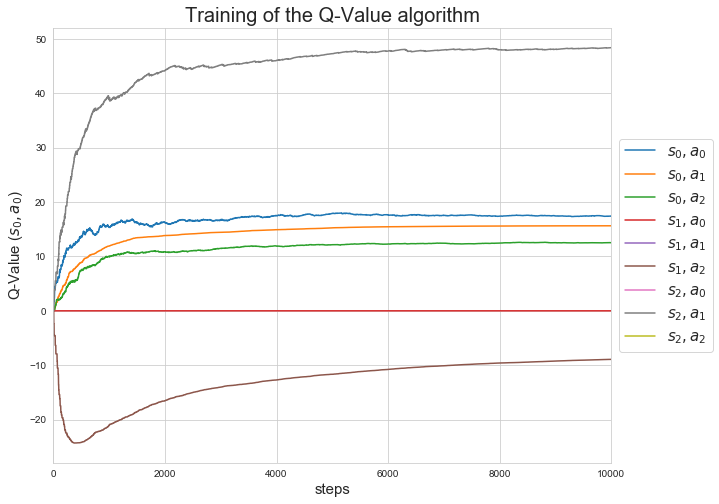

In [36]:
fig = plt.figure(figsize=(10, 8))


for state in range(3):
    for action in range(3):
        x = [qv[state][action] for qv in Q_values_history]
        plt.plot(x, label=f'$s_{state}, a_{action}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.title('Training of the Q-Value algorithm', fontsize=20)
plt.xlabel('steps', fontsize=15)
plt.ylabel('Q-Value ($s_0, a_0$)', fontsize=15)
plt.xlim((0, 10000))
plt.show()

### Exploration policies

Of course, we can do better than a random search to explore the unknown MDP.
A better algorithm is the *$\epsilon$-greedy policy*: at each step, the agent acts randomly with a probability $\epsilon$ or greedily by choosing the option with the highest Q-Value at a probability $1-\epsilon$.
It is common to also adjust $\epsilon$ from 1.0 down to 0.05 as training progresses.

An alternative method is to encourage the agent to try actions it hasn't tried before.
This can be implemented by adding a bonus to the Q-Value estimates as shown in the following equation:

$Q(s, a) \xleftarrow[\alpha]{} r + \gamma \cdot \max_{a'} f(Q(s', a', N(s', a'))$

where:

* $N(s', a')$ counts the number of times the action $a'$ has been chosen in state $s'$
* $f(Q, N)$ is an *exploration function* such as $f(Q, N) = Q + \kappa / (1 + N)$ where $\kappa$ is a hyperparamter controlling the influence of the count.

### Approximate Q-Learning and Deep Q-Learning

Q-Learning, however, does not scale well to larger systems because the search space grows exponentially with the number of states.

Instead, the Q-Values can be approximated by finding a function $Q_\theta(s,a)$ to approximate the Q-Value for any state-action pair $(s,a)$.
This is called *Approximate Q-Learning*, and for years it was accomplished by manually specifying the features to use.
However, in 2013, DeepMind demonstrated that a DNN, called a *Deep Q-Network* (DQN), could be taught to estimate the Q-Values through *Deep Q-Learning*.

The training of a DQN is similar to the methods we have seen before.
The Q-Value should be close to the reward observed after playing an action plus the discounted value of playing optimally from then on.
Thus, to estimate the sum of future discounted rewards, the DQN can be executed on the next state $s'$ and for all possible actions $a'$.
The highest value from this selection is then added to the rewards for the action to estimate the Q-Value.

$Q_\text{target}(s,a) = r + \gamma \cdot max_{a'} Q_\theta (s', a')$

This target Q-Value can be compared to the estimated Q-Value using MSE for the loss in a standard gradient descent algorithm.

## Implementing Deep Q-Learning

We first need a DQN that takes a state-action pair and outputs an approximate Q-Value.
In practice, though, it is more efficient to create a NN that takes a state and returns an approximate Q-Value for every possible action.

In [37]:
env = gym.make("CartPole-v0")
input_shape = env.observation_space.shape
n_outputs = env.action_space.n

In [38]:
dqn_model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])

The larget predicted Q-Value from the DQN will be used to select the next action.
However, for the exploration of the system, we will employ the $\epsilon$-greedy policy.

In [39]:
def epsilon_greedy_policy(mdl, state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = mdl.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

Instead of training the QDN on the latest experiences, all of the experiences will be stored in a *replay buffer* and small training batches will be randomly selected from it at each training iteration.
This helps reduce the correlations between the experiences in a training batch.
For this, we will use a deque list (a linked list).

In [40]:
from collections import deque

replay_buffer = deque(maxlen=2000)

Each experience will be composed of five elements: a state, the action the agent took, the resulting reward, the next state reached, and a boolean indicating whether the episode ended at that point (`done`).

We must make a function that randomly samples a batch of experiences from the replay buffer.
It should return five NumPy arrays corresponding to the five experience elements

In [41]:
def sample_experiences(replay_buffer, batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

Now we can create a function that plays a single step of the $\epsilon$-greedy policy and stores the resulting experience in the replay buffer.

In [42]:
def play_one_step(env, mdl, replay_buffer, state, epsilon):
    action = epsilon_greedy_policy(mdl, state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

We can create another function that samples a batch of experiences from the replay buffer and trains the DQN using a single gradient descent step.

In [43]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.mean_squared_error

In [44]:
def training_step(mdl, replay_buffer, optimizer, loss_fxn, batch_size, gamma):
    experiences = sample_experiences(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = mdl.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis = 1)
    target_Q_values = rewards + (1 - dones) * gamma * max_next_Q_values
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = mdl(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fxn(target_Q_values, Q_values))

    grads = tape.gradient(loss, mdl.trainable_variables)
    optimizer.apply_gradients(zip(grads, mdl.trainable_variables))

Finally, we can write the training loop.

In [45]:
rewards_history = []

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, dqn_model, replay_buffer,
                                                obs, epsilon)
        if done:
            break
    rewards_history.append(step)
    
    # early stopping
    if np.all([x > 190 for x in rewards_history[-3:]]):
        print(f'Stopping early at episode {episode}')
        break
    
    if episode > 50:
        training_step(dqn_model, replay_buffer, optimizer, loss_fn,
                      batch_size, discount_factor)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



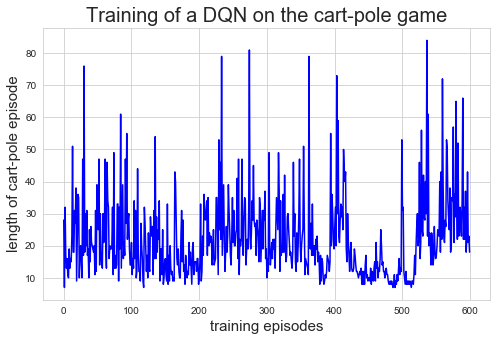

In [46]:
fig = plt.figure(figsize=(8, 5))
plt.plot(rewards_history, 'b-')
plt.xlabel('training episodes', fontsize=15)
plt.ylabel('length of cart-pole episode', fontsize=15)
plt.title('Training of a DQN on the cart-pole game', fontsize=20)
plt.show()

In [47]:
if False:
    obs = env.reset()
    while True:
        env.render()

        predicted_q_values = dqn_model(obs[np.newaxis]).numpy()[0]
        action = int(predicted_q_values[0] < predicted_q_values[1])
        obs, reward, done, info = env.step(action)

        if done:
            break

    env.close()
env.close()

Here is one of the stellar examples of this model defeating the cart-pole problem.

<img src="assets/ch18/images/DQN-model_1.gif" width=500 >

The training of the DQN is highly variable.
It takes awhile for noticeable improvement, and when there is finally a spike, it quickly drops back down to poor performance.
This is a noted issue with RL algorithms and is called *catastrophic forgetting*.
It often occurs when what the policy learns for one part of the environment breaks what it had learned for another part.
It demonstrates that RL is difficult and takes a lot of tuning of hyperparameters.

## Deep Q-Learning Variants

Below we will look at a few variants of the Deep Q-Learning algorithm that can stabilize and speed-up training.

### Fixed Q-Value targets

In the training regime used above, the model created both the predictions are the target values.
Instead, DeepMind used two DQN models: the *online model* learns at each step and moves the agent around, while the *target model* defined the targets.
The target model is just a clone of the online model, and is updated with the online model's weights at fixed intervals.

This is implemented below using two new DQN models, an updated `training_step()` function, and the weights are copied to the target model every 50 episodes.
(The hyperparameters likely need to be adjusted, but the structure is there.)

This method works because the target Q-Values become more stable, reducing the feedback loop that can happen if the DQN being trained is also producing the Q-Value targets.
The method does not work here, likely because I have not tuned the hyperparameters.
Also, since the target DQN is updated infrequently, usually more episodes are required for the training.

### Double DQN

In 2015, DeepMind realized a problem with the target DQN: it was prone to overestimating Q-Values.
Since the target Q-Values were only approximations, even if the true Q-Values were the same, there would be some differences in the target DQN's estimates.
Even if the error is only a small amount, it can still cause one action to consistently have a higher Q-Value than the others due to random chance.

To fix this, they proposed using the online model instead of the target model when selecting the best actions for the next states, using the target model only to estimate Q-Values for the best actions.
This has also been implemented below.

In [48]:
online_dqn = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])

target_dqn = keras.models.clone_model(online_dqn)
target_dqn.set_weights(online_dqn.get_weights())

In [49]:
def training_step2(online_mdl,
                   target_mdl,
                   replay_buffer,
                   optimizer,
                   loss_fxn,
                   batch_size,
                   gamma,
                   n_outputs):
    experiences = sample_experiences(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = online_mdl.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target_mdl.predict(next_states) * next_mask).sum(axis=1)
    
    target_Q_values = rewards + (1 - dones) * gamma * next_best_Q_values
    mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        all_Q_values = online_mdl(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fxn(target_Q_values, Q_values))

    grads = tape.gradient(loss, online_mdl.trainable_variables)
    optimizer.apply_gradients(zip(grads, online_mdl.trainable_variables))

In [50]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000)

rewards_history = []

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

for episode in range(400):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 600, 0.01)
        obs, reward, done, info = play_one_step(env, online_dqn, replay_buffer,
                                                obs, epsilon)
        if done:
            break
    rewards_history.append(step)
    
    # early stopping
    if np.all([x > 190 for x in rewards_history[-3:]]):
        print(f'Stopping early at episode {episode}')
        break
    
    if episode > 50:
        training_step2(online_dqn, target_dqn, 
                       replay_buffer, optimizer, loss_fn,
                       batch_size, discount_factor, n_outputs)
    
    if episode % 50 == 0:
        target_dqn.set_weights(online_dqn.get_weights())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



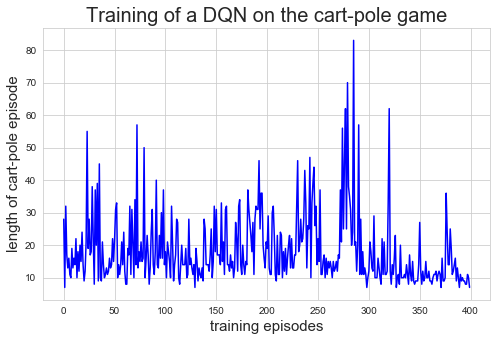

In [51]:
fig = plt.figure(figsize=(8, 5))
plt.plot(rewards_history, 'b-')
plt.xlabel('training episodes', fontsize=15)
plt.ylabel('length of cart-pole episode', fontsize=15)
plt.title('Training of a DQN on the cart-pole game', fontsize=20)
plt.show()

### Prioritized Experience Replay (PER)

Up to now, the experiences used for training have been randomly sampled from the replay buffer.
PER is a method for sampling the most important experiences more frequently.
The importance of an experience can be estimated using the TD (Temporal Difference) error, $\delta = r + \gamma \cdot V(s') - V(s)$, because a large TD error indicates a transition $(s, r, s')$ was suprizing and probably worth learning from.

To implement this, when an experience is recorded in the replay buffer, its priority is set very high to ensure it gets sampled at least once.
Once it is sampled, the TD error $\delta$ is calculated and its priority is set as $p = |\delta| + \epsilon$ (where $\epsilon$ is just a small non-zero value).
The probability $P$ os sampling an experience with priority $p$ is proportional to $p^\zeta$, where $\zeta$ is a hyperparameter controlling how much the priority should matter; when $\zeta = 0$ the sampling is uniform, and when $\zeta = 1$, the sampling is determined by priority.
The optimal value for $\zeta$ will depend on the task.

To prevent overfitting to the more important experiences, the impact of the training should be downweighted according the the importance of the experiences.
Thus, because the more important experiences will get used more often, they must be given a lower weight during training.
The training weight can be calculated as $w = (nP)^{-\beta}$, where $n$ is the number of experiences in the replay buffer and $\beta$ is a hyperparameter to control the level of compensation to apply.
When this method was introduced, the authors started with $\beta = 0.4$ and increased it to $\beta = 1$ over the training processes.

### Dueling DQN (DDQN)

The Q-Value of a state-action pair $(s,a)$ can be described as $Q(s,a) = V(s) + A(s,a)$ where $V(s)$ is the value of state $s$ and $A(s,a)$ is the *advantage* of taking action $a$ in state $s$ compared to all other possible actions in the state.
If the Q-Value of a state is equal to the Q-Value of the best action $a^*$ for that state, then $V(s) = Q(s,a^*)$ and $A(s,a^*) = 0$.
In a Dueling DQN (DDQN), the model estimates both the value of the state and the advantage of each possible action.
Since the best action should have a value of 0, the model subtracts the maximum predicted advantage from all predicted advantages.
Below is a DDQN model built using the functional API.

In [52]:
K = keras.backend

input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation='elu')(input_states)
hidden2 = keras.layers.Dense(32, activation='elu')(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.Model(inputs=[input_states], outputs=[Q_values])

## The TF-Agents library

The TF-Agents library is a Reinforcement Learning library based on TF.
It provides many environments, including wrapping around OpenAI Gym, physics engines, and models.
We will use it to train a DQN to play the Atari game *Breakout*.

### TG-Agents environment

We can create Breakout environment which is a wrapper around an OpenAI Gym environment.

In [53]:
from tf_agents.environments import suite_gym

breakout_env = suite_gym.load('Breakout-v4')
breakout_env

There are some differences between the APIs of OpenAI Gym and TF-Agents.
For instance, calling the `reset()` method of an environment does not return just the observations, but a `TimeStep` object with a bunch of information.

In [54]:
breakout_env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [55]:
breakout_env.step(1)

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

We can also get the parameters of an environment through specific methods.

In [56]:
breakout_env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [57]:
breakout_env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [58]:
breakout_env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [59]:
breakout_env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

### Environment wrappers and Atari preprocessing

TF-Agents includes *environment wrappers*: wrappers for environments that are automatically involved in very step of the environment and add some extra functionality.
Here are some that seem quite useful:

* `ActionClipWrapper`: Clips the actions to the action specification.
* `ActionDiscretizeWrapper`: If an environment has actions on a continuous scale, this can turn them into a specified number of discrete steps.
* `ActionRepeat`: Repeats each action for multiple steps, accumulating the rewards - this can be useful to speed up the training in some environments.
* `RunStats`: Records environment statistics.
* `TimeLimit`: Interrupts the environment if it runs for longer than a maximum number of steps.
* `VideoWrapper`: Records a video of the environment.

The wrappers for Atari environments are fairly standardized - greyscale and downsampling the observations, max pooling of the last two frames of the game using a 1x1 filter, frame skipping (the default is to skip every 4 frames), end-of-life loss (whether or not to end the game after the player loses a life).

We will not use the frame skipping in this case, but will apply a wrapper that merges 4 frames into one (it helps the agent learn about the direction the ball is moving in).

In [60]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environment_name = 'BreakoutNoFrameskip-v4'

breakout_env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

Lastly, we can wrap this environment in `TFPyEnvironment` so it is usable from within a TF graph.

In [61]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(breakout_env)

### Training architecture

The TF-Agents training program is usually split into two components, *Collection* and *Training*, and are run in parallel.
These two pieces are shown in the diagram below.

![](assets/ch18/images/tf-agents_training_architecture.jpg)

On the left, the driver explores the environments using a collect policy to choose actions.
The driver collections *trajectories* (i.e. experiences) and sends them to an observer to be saved to the replay buffer.
On the right, an agent selects batches of trajectories from the replay buffer and trains some networks which the collect policy can use, too.
Overall, the pieces on the left explore the environment and collect trajectories, while the pieces on the right learn and update the collect policy.

Now we can create the components one at a time.

### Creating the Deep Q-Network

The TF-Agents library offers many networks in the `tf_agents.networks` module and submodules.

In [67]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.0
)

conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

We used the `tf_agents.networks.q_network.QNetwork`.
The first two arguments are the `input_tensor_spec` and `action_spec` for the environment.
This is followed by a preprocessing layer that casts the data to 32-bit floats and normalizes the data to fall between 0 and 1.
There are 3 convolutional layers: 32 8x8 filters with stride 4, 64 4x4 filters with a stride of 2, and 64  3x3 filters with a stride of 1.
The last layer is a dense layer with 512 units.
The output is automatically a dense network with the number of units as there are actions (4 in this case).
All layers except for the output layer use a ReLU action funtion, though this can be adjusted using the `activation_fc` argument.
The outputs do not have an activation function and represent the Q-Values for each action given the input state.

### Creating the DQN agent

The TF-Agents library has many types of agents implemented in the `tf_agents.agents` module and its submodules.
We will the use `tf_agents.agents.dqn.dqn_agent.DqnAgent` class and notes on the following code are below.

In [69]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(learning_rate=1.5e-4,
                                     rho=0.95,
                                     momentum=0.0,
                                     epsilon=0.00001,
                                     centered=True)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01
)

agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction='none'),
    gamma=0.99,
    train_step_counter=train_step,
    epsilon_greedy=lambda: epsilon_fn(train_step)
)

agent.initialize()

1. The `train_step` variable will track the training step number and the model will be trained every `update_period` steps.
2. The optimizer is created and the hyperparameters were taken from one of the original DQN papers from 2015.
3. The `epsilon_fn` variable is a `PolynomialDecay` object that will compute the $\epsilon$ value for the $\epsilon$-greedy collect policy, given the current training step. It will scale down from 1.0 to 0.01 over 1 million ALE frames, or 250,000 steps (since we skip with a period of 4). Further, we will training the agent every 4 steps (16 ALE frames), so $\epsilon$ will actually decay over 62,500 training steps.
4. The `DQNAgent` is then built, passing it the time step and action specifications for the environment. It is also given the `QNetwork` we built previously, the optimizer, the number of training steps between target model updates, the loss function to use, the discount factor $\gamma$, the `train_step` variable, and a function with no arguments that returns the $\epsilon$. For the loss function, `reduction = none` prevents the function from taking the mean loss over all instances, and instead returns an error for each instance.
5. The agent is initialized at the end.

### Creating the replay buffer and corresponding observer